<center><h1> TD Réseaux de Neurones </h1></center>

Pour ce dernier TD vous allez devoir réaliser 2 modélisations différentes.
Une première pour une régression sur le jeu de données california housing et le second une classification de vêtement.

#### Préambule 

Jouer sur le [tensor sandbox](https://playground.tensorflow.org/) pour voir l'effet des hyperparamètres.


#### Première partie, régression

L'objectif est de jouer sur les hyperparamètres et de regarder l'impact sur les courbes d'apprentissages

1-) Charger le jeu de données Auto MPG disponible sur le site [UCI](https://archive.ics.uci.edu/ml/index.php)

2-) Adapter votre jeu de données pour faire une régression sous Keras

3-) Faites un premier modèle de régression avec Keras en utilisant l'API séquentiel

4-) Tester un modèle wide & deep

5-) Faire une cross-validation avec scikeras pour trouver le meilleur modèle

#### Seconde partie, classification

1-) Charger le jeu de données fashion mnist

2-) Visualiser le contenu du dataset, des images

3-) Transformer les features et créer un jeu de test et d'entrainement

4-) Réaliser des modèles de classification avec keras

### Import package

In [61]:
#Get package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV 
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor


### Code, régression

#### 1-) Charger le jeu de données Auto MPG disponible sur le site UCI

In [62]:
#Pour charger le jeu de données
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model_year', 'origin']

df = pd.read_csv(url, 
                 names=column_names,
                 na_values='?', 
                 comment='\t',
                 sep=' ', 
                 skipinitialspace=True
                 )

In [63]:
df

,MPG,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


#### 2-) Adapter votre jeu de données pour faire une régression sous Keras

In [64]:
# Vérifier les valeurs manquantes
df.isna().sum()

# Supprimer les lignes avec des valeurs manquantes
df = df.dropna()


In [65]:
from sklearn.preprocessing import OneHotEncoder

# Encodage de la variable 'origin'
ohe = OneHotEncoder(sparse_output=False)  # Utiliser sparse_output à la place de sparse
origin_encoded = ohe.fit_transform(df[['origin']])

# Créer des noms de colonnes pour les variables encodées
origin_columns = ['origin_1', 'origin_2', 'origin_3']
df_encoded = pd.DataFrame(origin_encoded, columns=origin_columns)

# Ajouter les variables encodées au dataframe original et supprimer la colonne 'origin'
df = df.drop('origin', axis=1)
df = pd.concat([df, df_encoded], axis=1)



In [66]:
# Séparer les features (X) et la cible (y)
X = df.drop('MPG', axis=1)
y = df['MPG']


In [67]:
from sklearn.preprocessing import StandardScaler

# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [68]:
from sklearn.model_selection import train_test_split

# Séparer en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [69]:
import numpy as np
from sklearn.impute import SimpleImputer

# Imputation pour X_train
imputer_X = SimpleImputer(strategy='mean')  # Vous pouvez aussi utiliser 'median'
X_train = imputer_X.fit_transform(X_train)

# Conversion de y_train en tableau NumPy avant imputation
y_train = np.array(y_train)  # Conversion en tableau NumPy si ce n'est pas déjà fait

# Imputation pour y_train
imputer_y = SimpleImputer(strategy='mean')
y_train = imputer_y.fit_transform(y_train.reshape(-1, 1)).ravel()


In [70]:
# Masque pour les lignes valides
valid_mask = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)

# Garder uniquement les lignes valides
X_train = X_train[valid_mask]
y_train = y_train[valid_mask]


In [71]:
print(np.any(np.isnan(X_train)), np.any(np.isnan(y_train)))  # Devrait retourner False, False
print(np.any(np.isinf(X_train)), np.any(np.isinf(y_train)))  # Devrait retourner False, False


False False
False False


#### 3-) Faites un premier modèle de régression avec Keras en utilisant l'API séquentiel

Attention, il faudra surement changer voter otpimizer pour ce problème.

**Jouer avec les hyperparamètres pour voir comment se comporter le modèle**

In [72]:
#Lancer ce code pour nettoyer votre session keras avec chaque nouveau modèle et fixer la graine

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

# Créer un modèle séquentiel
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Couche d'entrée
    Dense(64, activation='relu'),  # Couche cachée
    Dense(1)  # Couche de sortie
])

# Compiler le modèle avec un optimiseur et une fonction de perte pour la régression
model.compile(optimizer=Adam(learning_rate=0.001),  # Essayer aussi SGD avec différents taux d'apprentissage
              loss='mse',  # Erreur quadratique moyenne (Mean Squared Error)
              metrics=['mae'])  # Ajouter l'erreur absolue moyenne (Mean Absolute Error)

# Entraîner le modèle
history = model.fit(X_train, y_train,
                    epochs=100,  # Jouer avec le nombre d'époques
                    batch_size=32,  # Essayer des tailles de batch différentes
                    validation_split=0.2,  # Garder 20% pour la validation
                    verbose=1)

# Évaluer le modèle sur les données de test
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss sur le jeu de test: {test_loss:.4f}, MAE: {test_mae:.4f}")


Epoch 1/100


C:\Users\lucas\anaconda3\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 612.5929 - mae: 23.4303 - val_loss: 672.0298 - val_mae: 24.6716
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 587.3895 - mae: 22.8879 - val_loss: 645.5875 - val_mae: 24.1373
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 562.4592 - mae: 22.3396 - val_loss: 616.3667 - val_mae: 23.5321
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 534.1032 - mae: 21.6995 - val_loss: 579.4299 - val_mae: 22.7486
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 498.6673 - mae: 20.8784 - val_loss: 532.2143 - val_mae: 21.7183
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 454.0366 - mae: 19.8092 - val_loss: 473.6780 - val_mae: 20.3832
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 399.6248 - mae: 18.4323 - val_loss: 403.7798 - val_mae: 18.6788
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 336.1181 - mae: 16.7025 - val_loss: 324.5384 - val_mae: 16.5675
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━

ValueError: Cannot take the length of shape with unknown rank.

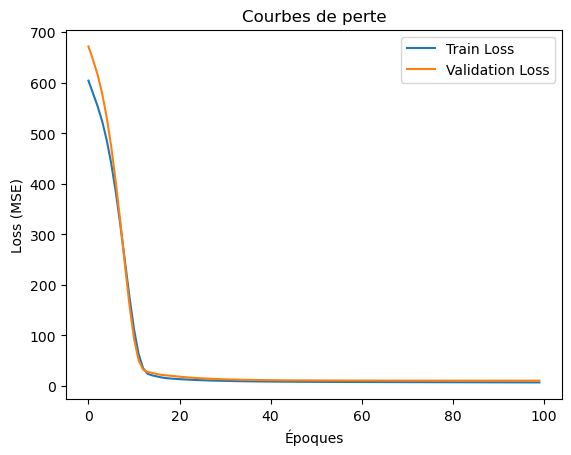

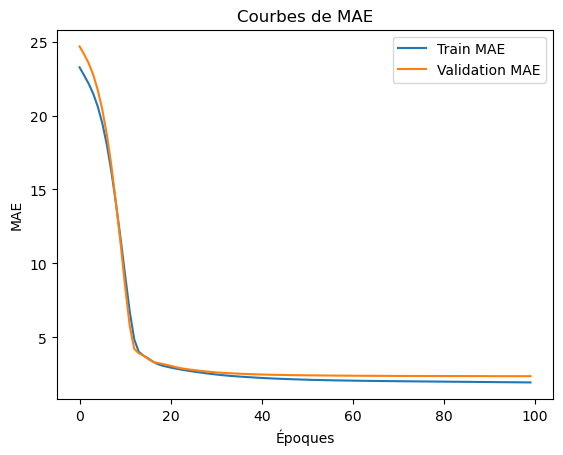

In [74]:
import matplotlib.pyplot as plt

# Courbes de perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Époques')
plt.ylabel('Loss (MSE)')
plt.title('Courbes de perte')
plt.legend()
plt.show()

# Courbes de MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.title('Courbes de MAE')
plt.legend()
plt.show()


#### 4-) Tester un modèle wide & deep
**Jouer avec les hyperparamètres pour voir comment se comporter le modèle**

In [75]:
#Lancer ce code pour nettoyer votre session keras avec chaque nouveau modèle et fixer la graine

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

# Définir l'entrée
input_layer = Input(shape=(X_train.shape[1],))

# Modèle "Wide" (simplement une couche dense sans activation)
wide_layer = Dense(1)(input_layer)

# Modèle "Deep" (plus complexe avec des couches cachées)
deep_layer = Dense(64, activation='relu')(input_layer)
deep_layer = Dense(64, activation='relu')(deep_layer)
deep_layer = Dense(32, activation='relu')(deep_layer)

# Combiner les sorties des modèles "wide" et "deep"
merged = Concatenate()([wide_layer, deep_layer])

# Couche finale pour la régression
output_layer = Dense(1)(merged)

# Créer le modèle
model_wide_deep = Model(inputs=input_layer, outputs=output_layer)

# Compiler le modèle avec un optimiseur et une fonction de perte pour la régression
model_wide_deep.compile(optimizer=Adam(learning_rate=0.001),
                        loss='mse',
                        metrics=['mae'])

# Entraîner le modèle
history_wide_deep = model_wide_deep.fit(X_train, y_train,
                                       epochs=100,
                                       batch_size=32,
                                       validation_split=0.2,
                                       verbose=1)

# Évaluer le modèle sur le jeu de test
test_loss_wide_deep, test_mae_wide_deep = model_wide_deep.evaluate(X_test, y_test, verbose=0)
print(f"Loss sur le jeu de test (Wide & Deep): {test_loss_wide_deep:.4f}, MAE: {test_mae_wide_deep:.4f}")


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 592.0529 - mae: 23.1214 - val_loss: 645.5613 - val_mae: 24.2640
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 566.0668 - mae: 22.5658 - val_loss: 611.1727 - val_mae: 23.5623
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 532.2526 - mae: 21.8224 - val_loss: 560.0231 - val_mae: 22.4842
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 481.4068 - mae: 20.6614 - val_loss: 484.8113 - val_mae: 20.7989
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 407.4617 - mae: 18.8425 - val_loss: 380.3133 - val_mae: 18.1843
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 306.5898 - mae: 16.0151 - val_loss: 248.5945 - val_mae: 14.2187
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 186.6638 - mae: 11.9975 - val_loss: 117.8980 - val_mae: 9.1226
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 84.3185 - mae: 7.8518 - val_loss: 50.6192 - val_mae: 5.8204
Epoch 9/100
8/8 ━━━━━━━━━━━━━

ValueError: Cannot take the length of shape with unknown rank.

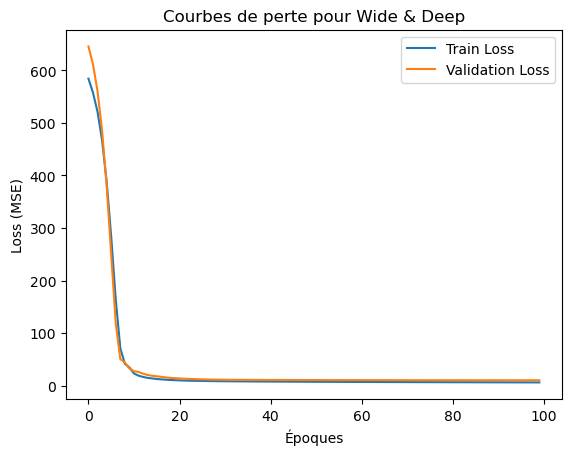

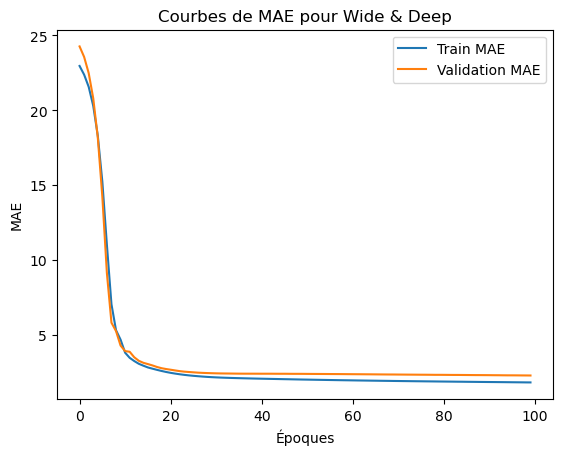

In [77]:
# Visualiser les courbes de perte et MAE
plt.plot(history_wide_deep.history['loss'], label='Train Loss')
plt.plot(history_wide_deep.history['val_loss'], label='Validation Loss')
plt.xlabel('Époques')
plt.ylabel('Loss (MSE)')
plt.title('Courbes de perte pour Wide & Deep')
plt.legend()
plt.show()

plt.plot(history_wide_deep.history['mae'], label='Train MAE')
plt.plot(history_wide_deep.history['val_mae'], label='Validation MAE')
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.title('Courbes de MAE pour Wide & Deep')
plt.legend()
plt.show()

In [78]:
#Lancer ce code pour nettoyer votre session keras avec chaque nouveau modèle et fixer la graine

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Fixer la graine pour la reproductibilité
tf.random.set_seed(42)
np.random.seed(42)

# Définir l'entrée
input_layer = Input(shape=(X_train.shape[1],))

# Modèle "Wide" (simplement une couche dense sans activation)
wide_layer = Dense(1)(input_layer)

# Modèle "Deep" (plus complexe avec des couches cachées)
deep_layer = Dense(128, activation='relu')(input_layer)  # Couche cachée 1
deep_layer = Dropout(0.3)(deep_layer)  # Dropout pour éviter le surajustement
deep_layer = Dense(128, activation='relu')(deep_layer)  # Couche cachée 2
deep_layer = Dropout(0.3)(deep_layer)  # Dropout
deep_layer = Dense(64, activation='relu')(deep_layer)  # Couche cachée 3

# Combiner les sorties des modèles "wide" et "deep"
merged = Concatenate()([wide_layer, deep_layer])

# Couche finale pour la régression
output_layer = Dense(1)(merged)

# Créer le modèle
model_wide_deep = Model(inputs=input_layer, outputs=output_layer)

# Compiler le modèle avec un optimiseur et une fonction de perte pour la régression
# Choisir l'optimiseur
optimizer = SGD(learning_rate=0.001)  # Tester avec Adam ou SGD

# Compiler le modèle
model_wide_deep.compile(optimizer=optimizer,
                        loss='mse',
                        metrics=['mae'])

# Définir la stratégie d'arrêt anticipé (EarlyStopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraîner le modèle avec EarlyStopping
history_wide_deep = model_wide_deep.fit(X_train, y_train,
                                       epochs=50,  # Nombre d'époques
                                       batch_size=32,
                                       validation_split=0.2,  # Garder 20% des données pour la validation
                                       callbacks=[early_stopping],
                                       verbose=1)

# Évaluer le modèle sur le jeu de test
test_loss_wide_deep, test_mae_wide_deep = model_wide_deep.evaluate(X_test, y_test, verbose=0)
print(f"Loss sur le jeu de test (Wide & Deep): {test_loss_wide_deep:.4f}, MAE: {test_mae_wide_deep:.4f}")




Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 578.9322 - mae: 22.8663 - val_loss: 522.4372 - val_mae: 21.8004
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 341.3032 - mae: 16.8054 - val_loss: 36.1717 - val_mae: 4.4188
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 42.1193 - mae: 5.3113 - val_loss: 27.0926 - val_mae: 3.8134
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 27.2067 - mae: 4.1624 - val_loss: 28.3630 - val_mae: 4.1775
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 28.4215 - mae: 4.3465 - val_loss: 20.3879 - val_mae: 3.3600
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 23.8802 - mae: 3.8599 - val_loss: 19.2587 - val_mae: 3.3005
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 25.2360 - mae: 3.7978 - val_loss: 15.1867 - val_mae: 2.7606
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 23.3070 - mae: 3.7504 - val_loss: 16.4310 - val_mae: 3.0319
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2

ValueError: Cannot take the length of shape with unknown rank.

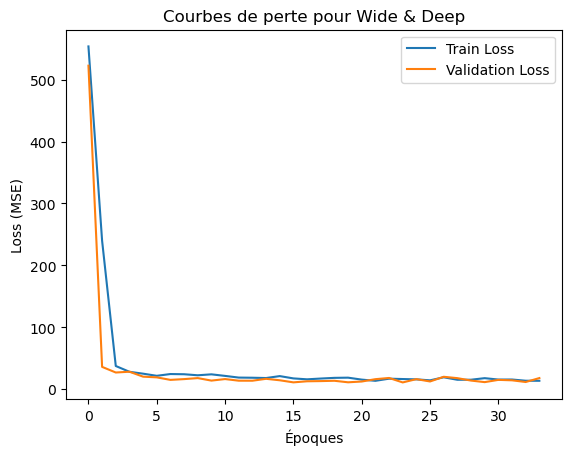

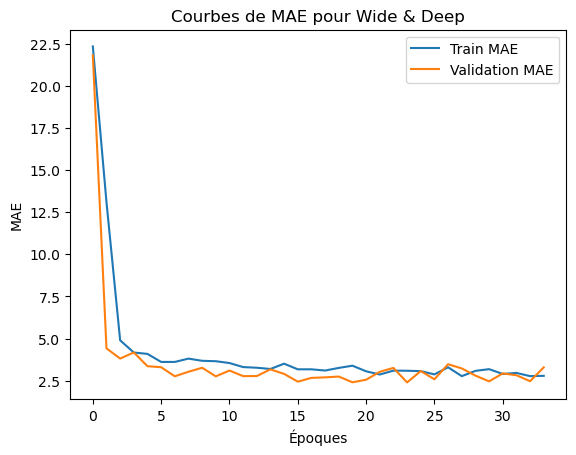

In [80]:
# Visualiser les courbes de perte (MSE) et MAE
plt.plot(history_wide_deep.history['loss'], label='Train Loss')
plt.plot(history_wide_deep.history['val_loss'], label='Validation Loss')
plt.xlabel('Époques')
plt.ylabel('Loss (MSE)')
plt.title('Courbes de perte pour Wide & Deep')
plt.legend()
plt.show()

plt.plot(history_wide_deep.history['mae'], label='Train MAE')
plt.plot(history_wide_deep.history['val_mae'], label='Validation MAE')
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.title('Courbes de MAE pour Wide & Deep')
plt.legend()
plt.show()

#### 5-) Faire une cross-validation avec scikeras pour trouver le meilleur modèle

In [81]:
#Lancer ce code pour nettoyer votre session keras avec chaque nouveau modèle et fixer la graine

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Fonction pour créer le modèle avec un paramètre dropout_rate
def create_model(dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Création de l'estimateur avec KerasRegressor
model = KerasRegressor(model=create_model, dropout_rate=0.3)

# Paramètres à tester dans la recherche par grille
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Recherche par grille
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Entrainer la recherche par grille
grid_result = grid_search.fit(X_train, y_train)

# Résultats
print(f"Meilleur score : {grid_result.best_score_}")
print(f"Meilleurs paramètres : {grid_result.best_params_}")


In [ ]:
Seconde partie, classification

#### 1-) Charger le jeu de données fashion mnist

In [83]:
#Load fashion mnist
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) =fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### 2-) Visualiser le contenu du dataset, des images

In [84]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

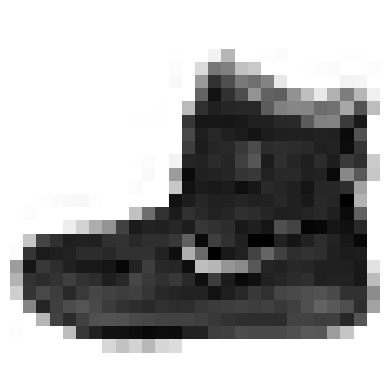

In [91]:
import matplotlib.pyplot as plt

# Afficher une image
plt.imshow(X_train_full[0], cmap="binary")  # Ici, on affiche la première image du dataset
plt.axis('off')  # Désactive les axes
plt.show()


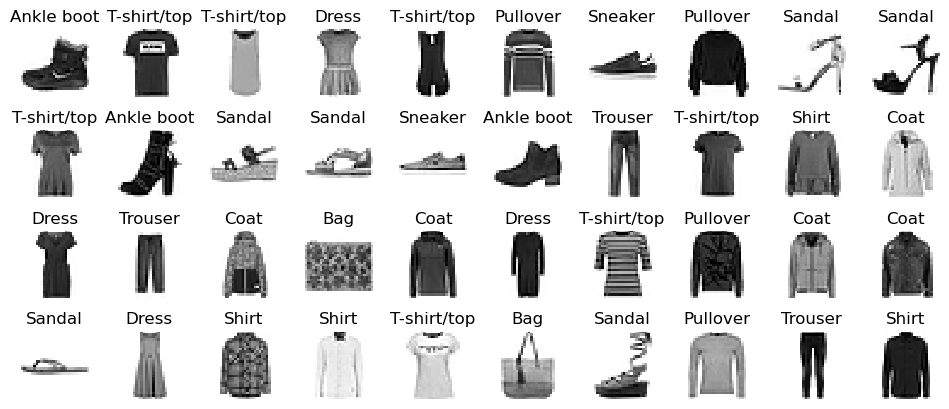

In [93]:
import matplotlib.pyplot as plt

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")  # Afficher l'image
        plt.axis('off')
        plt.title(class_names[y_train_full[index]], fontsize=12)  # Afficher le titre avec le nom de la classe
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


In [ ]:
3-) Transformer les features et créer un jeu de test et d'entrainement

In [94]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist

# Charger le dataset
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Normaliser les données (de 0-255 à 0-1)
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Transformer les labels en catégories (si nécessaire)
y_train_full = np.array(y_train_full)
y_test = np.array(y_test)

# Diviser le jeu d'entraînement en un jeu d'entraînement et un jeu de validation (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Affichage des tailles des jeux de données
print(f"Jeu d'entraînement: {X_train.shape}, Jeu de validation: {X_val.shape}, Jeu de test: {X_test.shape}")


Jeu d'entraînement: (48000, 28, 28), Jeu de validation: (12000, 28, 28), Jeu de test: (10000, 28, 28)


In [95]:
# Ajouter une dimension de canal (1 pour les images en niveau de gris)
X_train = np.expand_dims(X_train, axis=-1)  # (60000, 28, 28, 1)
X_val = np.expand_dims(X_val, axis=-1)  # (12000, 28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)  # (10000, 28, 28, 1)

# Affichage des dimensions des données
print(f"Dimensions du jeu d'entraînement : {X_train.shape}")
print(f"Dimensions du jeu de validation : {X_val.shape}")
print(f"Dimensions du jeu de test : {X_test.shape}")


Dimensions du jeu d'entraînement : (48000, 28, 28, 1)
Dimensions du jeu de validation : (12000, 28, 28, 1)
Dimensions du jeu de test : (10000, 28, 28, 1)


#### 4-) Réaliser des modèles de classification avec keras

Attention à votre fonction de perte ici. Choissisez la *keras.losses.sparse_categorical_crossentropy*

**Categorical Cross-Entropy and Sparse Categorical Cross-Entropy**<br>
Both categorical cross entropy and sparse categorical cross-entropy have the same loss function as defined in Equation 2. The only difference between the two is on how truth labels are defined.

Categorical cross-entropy is used when true labels are one-hot encoded, for example, we have the following true values for 3-class classification problem [1,0,0], [0,1,0] and [0,0,1].

In sparse categorical cross-entropy , truth labels are integer encoded, for example, [1], [2] and [3] for 3-class problem.


In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Construire le modèle CNN
model = Sequential([
    # Couche convolutive 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    
    # Couche convolutive 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Couche convolutive 3
    Conv2D(64, (3, 3), activation='relu'),
    
    # Aplatir les résultats des convolutions pour les passer aux couches denses
    Flatten(),
    
    # Couches denses
    Dense(128, activation='relu'),
    
    # Couche de sortie avec 10 neurones (pour 10 classes), activation softmax
    Dense(10, activation='softmax')
])

# Compiler le modèle avec sparse_categorical_crossentropy comme fonction de perte
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

# Évaluer sur le jeu de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


C:\Users\lucas\anaconda3\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,890 (511.29 KB)

 Trainable params: 130,890 (511.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.7128 - loss: 0.7940 - val_accuracy: 0.8547 - val_loss: 0.3940
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8657 - loss: 0.3668 - val_accuracy: 0.8721 - val_loss: 0.3515
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.8859 - loss: 0.3098 - val_accuracy: 0.8831 - val_loss: 0.3212
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8992 - loss: 0.2763 - val_accuracy: 0.8906 - val_loss: 0.3035
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.9091 - loss: 0.2499 - val_accuracy: 0.8970 - val_loss: 0.2867
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8986 - loss: 0.2975
Test accuracy: 0.897599995136261


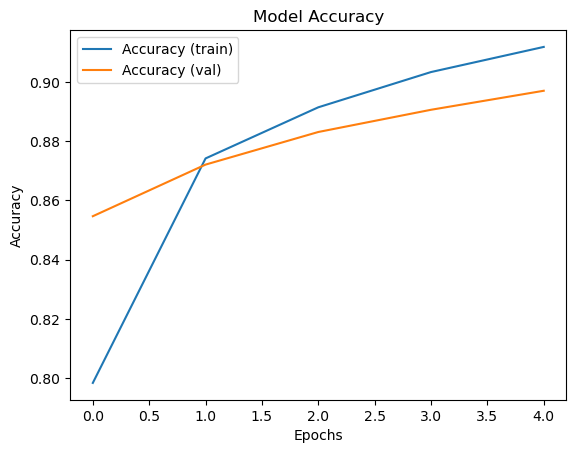

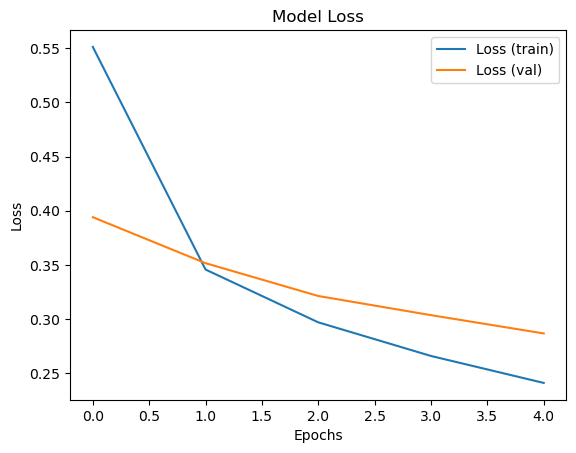

In [97]:
import matplotlib.pyplot as plt

# Afficher la courbe d'accuracy
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Afficher la courbe de loss
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
